In [1]:
import pandas as pd
import os
from utils import process_preds, evaluate_scores, evaluate_similarities, extract_legends_and_plot, keep_valid_molecules, check_pains_brenk, filter_for_rotatable_bonds, filter_for_nitrofuran, filter_for_sulfonamide, filter_for_logp_less_than, filter_for_mw_bounds, determine_optimal_clustering_number, deduplicate_on_tan_sim

/Users/jackie16201/Desktop/Spring_2023/ngonorrhoeae_abx_ml_discovery/src/utils.py:5: DeprecationWarning: The rdkit.Chem.MCS module is deprecated; please use rdkit.Chem.rdFMCS instead.
  from rdkit.Chem import MCS, Descriptors, PandasTools, AllChem
<frozen importlib._bootstrap>:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.


# PK+37K model on 800k dataset

In [2]:
# read in data
data_dir = '../out/predictions_from_models/pk_37k_model/800k/'
df = pd.read_csv(data_dir + 'broad800K_melis_predictions_04_25_2022.csv')
print('total number of predictions: ', len(df))
meta = pd.read_csv('../data/library_info/PublicStructures.txt', sep = '\t')
df = df.merge(meta, left_on = 'smiles', right_on = 'SMILES', how = 'left')
df = df.drop_duplicates()
df = df.reset_index(drop=True)
df.to_csv(data_dir + 'clean_preds_05_02_2022.csv', index = False)
df


total number of predictions:  799147


,smiles,hit,hit_epi_unc,Name,PROJECT_CODE,PROJECT_NAME,CXSMILES,STEREO_COMMENTS,SMILES
0,Cc1ccn(n1)CN1CCN(Cn2ccc(n2)C)C1=S,0.015454,0.000655,BRD-K08172813,2001,General HTS Sets,Cc1ccn(CN2CCN(Cn3ccc(C)n3)C2=S)n1,as drawn,Cc1ccn(n1)CN1CCN(Cn2ccc(n2)C)C1=S
1,C1OC(OC[C@H]2O[C@@H](O[C@@H]12)c1ccccc1)c1ccccc1,0.013225,0.000410,BRD-A88988282,2001,General HTS Sets,C1OC(OC[C@@H]2O[C@H](O[C@H]12)c1ccccc1)c1ccccc...,as drawn,C1OC(OC[C@H]2O[C@@H](O[C@@H]12)c1ccccc1)c1ccccc1
2,CN(C)CCOC(=O)c1ccc2[nH]c3c(c2c1)CSCC3,0.008279,0.000119,BRD-K29501884,2001,General HTS Sets,CN(C)CCOC(=O)c1ccc2[nH]c3CCSCc3c2c1,as drawn,CN(C)CCOC(=O)c1ccc2[nH]c3c(c2c1)CSCC3
3,CCN(CC)CCOc1ccc2nc(sc2c1)N(C)C,0.072864,0.008563,BRD-K03978601,2001,General HTS Sets,CCN(CC)CCOc1ccc2nc(sc2c1)N(C)C,as drawn,CCN(CC)CCOc1ccc2nc(sc2c1)N(C)C
4,CC1=CC(=O)O[C@@H]1Cc1ccc2ccccc2n1,0.011440,0.000161,BRD-A38938490,2001,General HTS Sets,"CC1=CC(=O)O[C@@H]1Cc1ccc2ccccc2n1 |&1:6,r,t:1|",as drawn,CC1=CC(=O)O[C@@H]1Cc1ccc2ccccc2n1
...,...,...,...,...,...,...,...,...,...
799142,Cc1cc(n(n1)[C@H]1CCS(=O)(=O)C1)NS(=O)(=O)c1c(n...,0.020572,0.000773,BRD-K00023370,5001,CMAP,Cc1cc(NS(=O)(=O)c2c(C)noc2C)n(n1)[C@H]1CCS(=O)...,as drawn,Cc1cc(n(n1)[C@H]1CCS(=O)(=O)C1)NS(=O)(=O)c1c(n...
799143,Fc1ccc(cc1)S(=O)(=O)CCCC(=O)Nc1nc-2c(s1)CSc1cc...,0.078468,0.006089,BRD-K00022740,5001,CMAP,Fc1ccc(cc1)S(=O)(=O)CCCC(=O)Nc1nc-2c(CSc3ccccc...,as drawn,Fc1ccc(cc1)S(=O)(=O)CCCC(=O)Nc1nc-2c(s1)CSc1cc...
799144,COc1cccc(c1)/C=C/1\Oc2cc(ccc2C1=O)O,0.119072,0.011544,BRD-K00022774,5001,CMAP,COc1cccc(\C=C2/Oc3cc(O)ccc3C2=O)c1,as drawn,COc1cccc(c1)/C=C/1\Oc2cc(ccc2C1=O)O
799145,CCc1ccc(cc1)S(=O)(=O)c1nnn2c3ccc(cc3c(nc12)N1C...,0.077788,0.002676,BRD-K00022896,5001,CMAP,CCc1ccc(cc1)S(=O)(=O)c1nnn2c1nc(N1CCC[C@@H](C)...,as drawn,CCc1ccc(cc1)S(=O)(=O)c1nnn2c3ccc(cc3c(nc12)N1C...


Total number in df:  799147
>0.1: 110790
>0.2: 49465
>0.30000000000000004: 27694
>0.4: 16899
>0.5: 10600
>0.6: 6771
>0.7000000000000001: 4216
>0.8: 2361
>0.9: 1055
Computing tanimoto scores against abx...


[18:40:58] WARNING: not removing hydrogen atom without neighbors


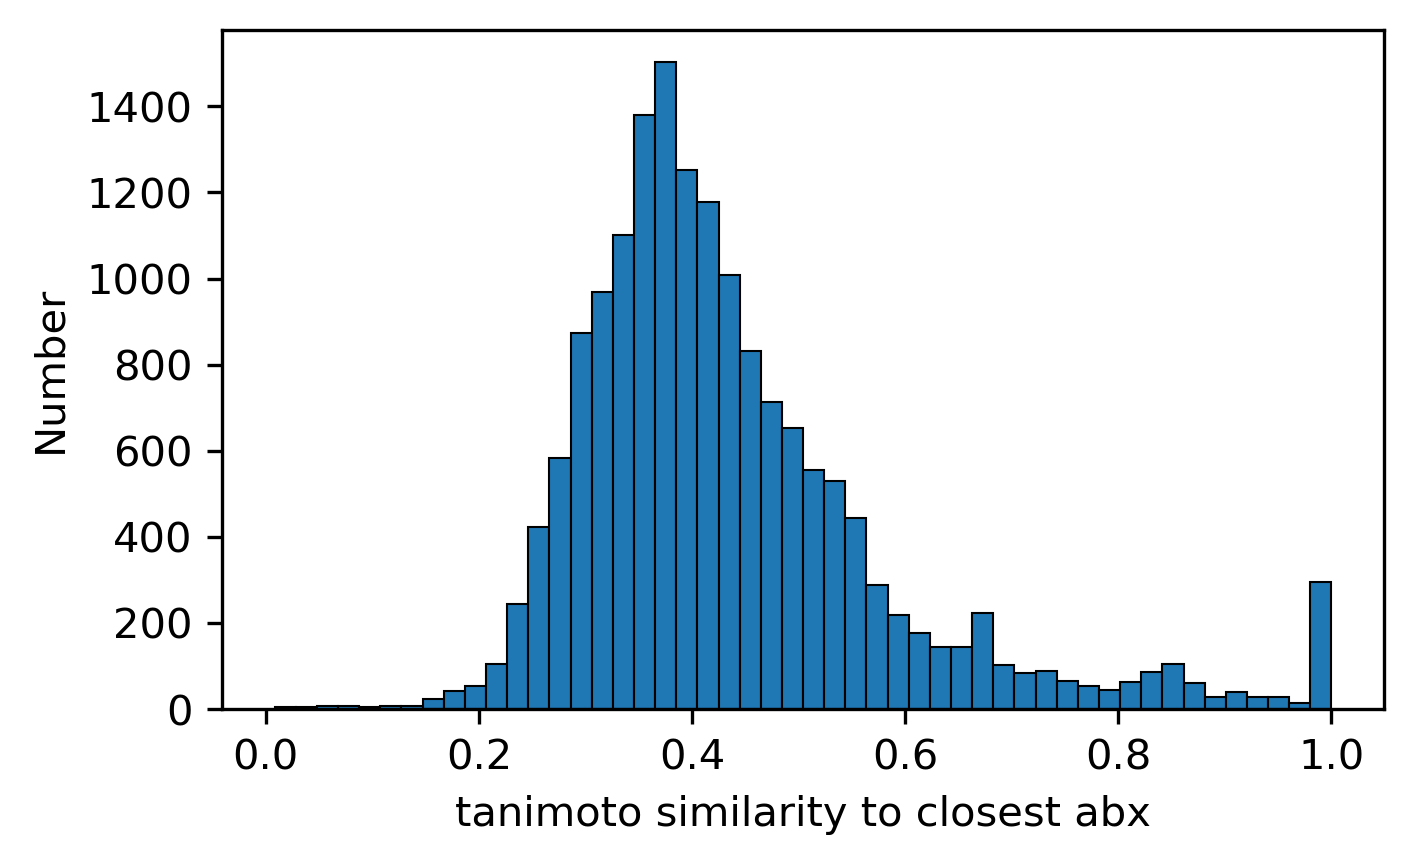

Computing tanimoto scores against training set...


[18:42:03] Unusual charge on atom 0 number of radical electrons set to zero


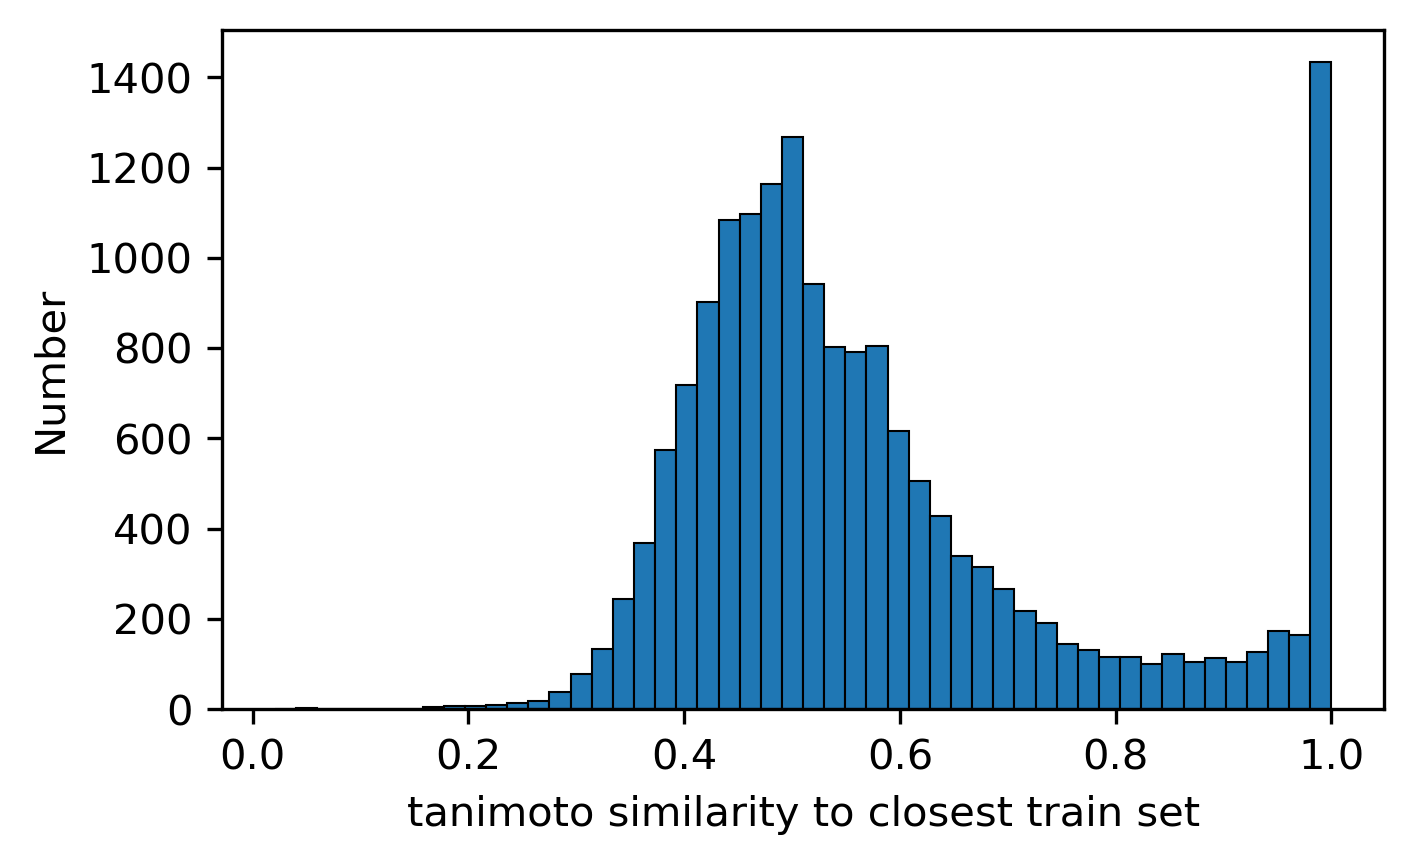

In [3]:
#process_preds(df, smiles_col = 'smiles', hit_col = 'hit', path = data_dir)
df = evaluate_scores(df, hit_col = 'hit')
df = df[df['hit'] > 0.4] # looks like a good score cut-off to start with
df = evaluate_similarities(df, smiles_col = 'smiles', path = data_dir, train_set_path = '../data/data_prep_for_ml/data_prep_for_ml_pk_37k_screen/FULL_03_19_2022.csv')
df.to_csv(data_dir + 'inh04_preds_with_tanimoto_analysis.csv', index = False)


In [3]:
data_dir = '../out/predictions_from_models/pk_37k_model/800k/'

# easy validation set - high scores, lenient similarity filtering
df = pd.read_csv(data_dir + 'inh04_preds_with_tanimoto_analysis.csv')
df = df[df['tanimoto similarity to closest abx'] < 0.9]
df = df[df['tanimoto similarity to closest train set'] < 0.9]
df = df[df['hit'] > 0.9]
print(len(df))

folder = data_dir + 'easy_val_set_inh09_tanabx09_tantrainset09/'
os.mkdir(folder)
df, mols = extract_legends_and_plot(df, 'easyval.png', folder, num_clusters = 25)
df.to_csv(folder + 'finalmols.csv', index = False)

414


In [4]:
# medium validation set - moderate-to-high scores, stricter similarity filtering
df = pd.read_csv(data_dir + 'inh04_preds_with_tanimoto_analysis.csv')
df = df[df['tanimoto similarity to closest abx'] < 0.5]
df = df[df['tanimoto similarity to closest train set'] < 0.5]
df = df[df['hit'] > 0.75]
print(len(df))

folder = data_dir + 'medium_val_set_inh075_tanabx05_tantrainset05/'
os.mkdir(folder)
df, mols = extract_legends_and_plot(df, 'mediumval.png', folder, num_clusters = 60)
df.to_csv(folder + 'finalmols.csv', index = False)

867


In [5]:
# hard validation set - low-to-moderate scores, very strict similarity filtering
df = pd.read_csv(data_dir + 'inh04_preds_with_tanimoto_analysis.csv')
df = df[df['tanimoto similarity to closest abx'] < 0.3]
df = df[df['tanimoto similarity to closest train set'] < 0.3]
df = df[df['hit'] > 0.4]
print(len(df))

folder = data_dir + 'hard_val_set_inh04_tanabx03_tantrainset03/'
os.mkdir(folder)
df, mols = extract_legends_and_plot(df, 'hardval.png', folder, num_clusters = 25)
df.to_csv(folder + 'finalmols.csv', index = False)

105


# PK+37K model on 5M commercially available dataset

Total number in df:  5348852
>0.1: 941082
>0.2: 389332
>0.30000000000000004: 204978
>0.4: 120531
>0.5: 73960
>0.6: 44948
>0.7000000000000001: 25722
>0.8: 12940
>0.9: 4333
Computing tanimoto scores against abx...


RDKit WARNING: [09:32:17] WARNING: not removing hydrogen atom without neighbors
[09:32:17] WARNING: not removing hydrogen atom without neighbors


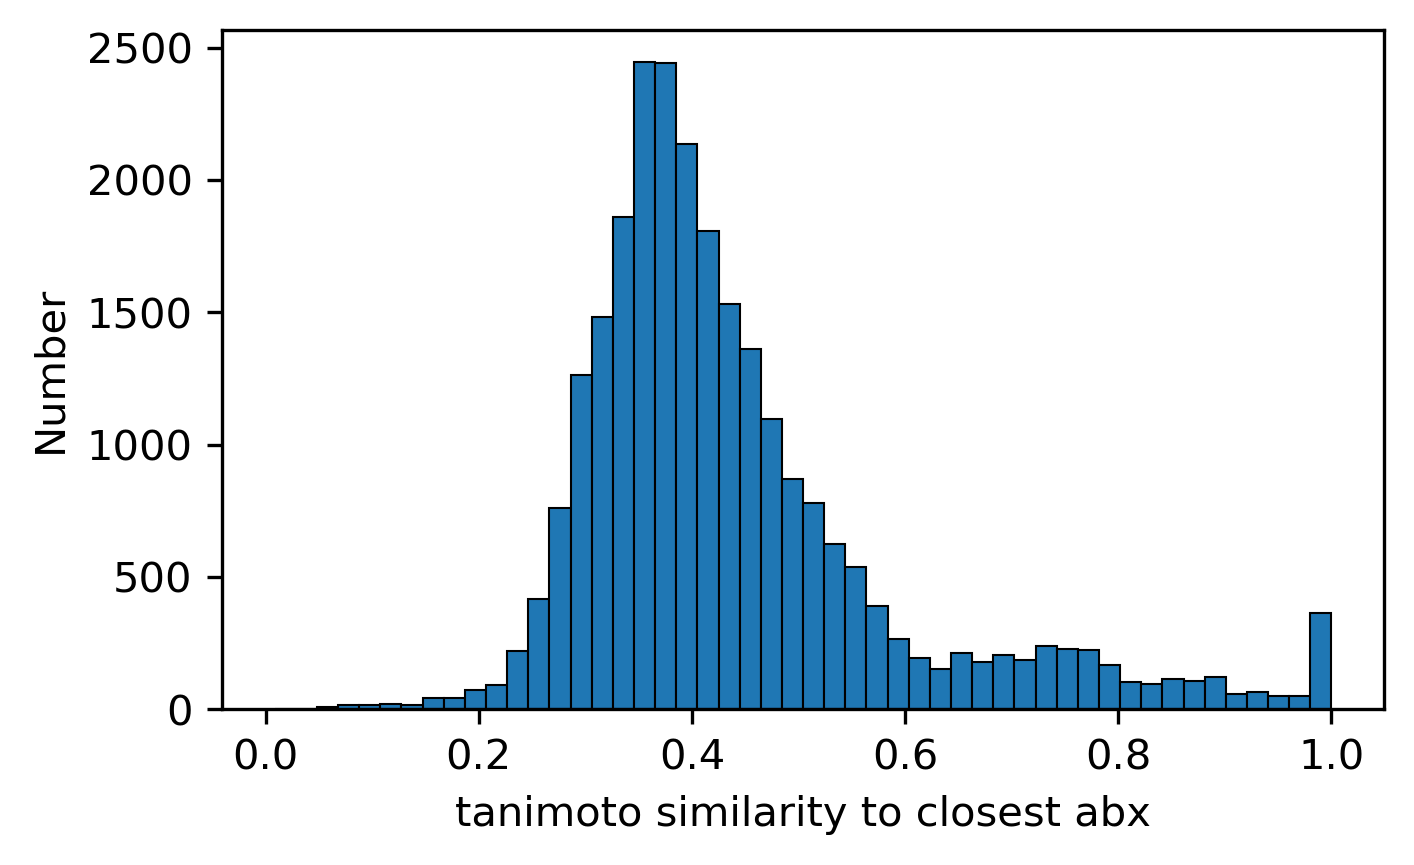

Computing tanimoto scores against training set...


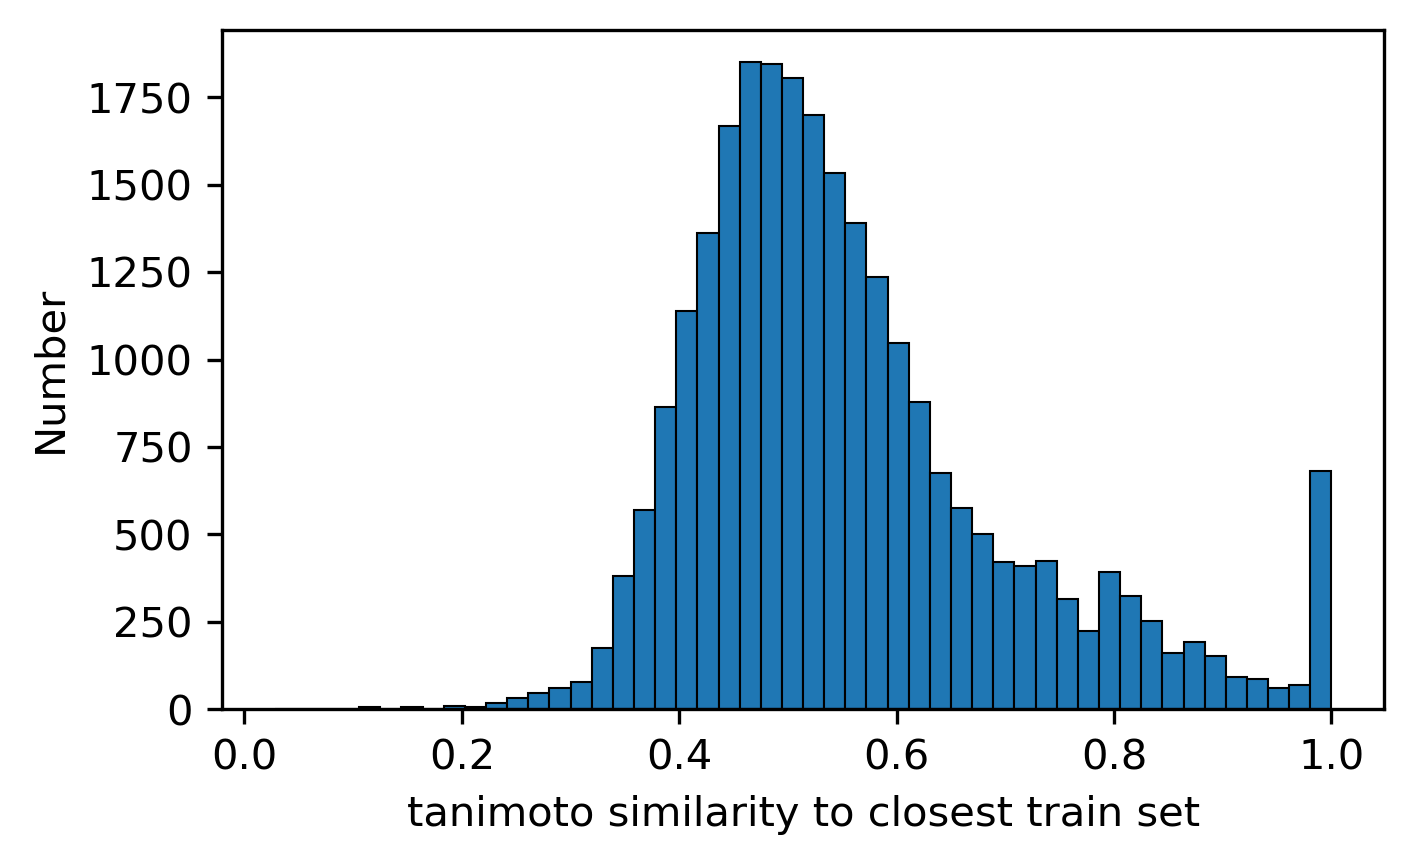

In [2]:
# read in data
data_dir = '../out/predictions_from_models/pk_37k_model/5M/'
df = pd.read_csv(data_dir + 'extended_screen_set_melis_predictions_05_01_2022.csv')
df = df.reset_index(drop=True)
df.to_csv(data_dir + 'clean_preds_05_02_2022.csv', index = False)

df = evaluate_scores(df, hit_col = 'hit')
df = df[df['hit'] > 0.7] # looks like a good score cut-off to start with
df = evaluate_similarities(df, smiles_col = 'SMILES', path = data_dir, train_set_path = '../data/data_prep_for_ml/data_prep_for_ml_pk_37k_screen/FULL_03_19_2022.csv', thresh_name = '07')
df.to_csv(data_dir + 'inh07_preds_with_tanimoto_analysis.csv', index = False)

In [3]:
# read in data
data_dir = '../out/predictions_from_models/pk_37k_model/5M/'
df = pd.read_csv(data_dir + 'inh07_preds_with_tanimoto_analysis.csv')
df = df[df['tanimoto similarity to closest abx'] < 0.5]
df = df[df['tanimoto similarity to closest train set'] < 0.9]
df = df.sort_values('hit', ascending = False)
df = df[df['hit'] < 0.9] # only look at those < 0.9 for maximum novelty
df = df[df['hit'] > 0.85] # only look at those >0.85 for now

# keep only valid frags
df, mols = keep_valid_molecules(df, 'SMILES')

# keep only frags without pains or brenk
df, mols = check_pains_brenk(df, mols, method = 'pains', thresh=0)
df, mols = check_pains_brenk(df, mols, method = 'brenk', thresh=2)

# filter for rotatable bonds
df, mols = filter_for_rotatable_bonds(df, mols, 'SMILES', 5)

# filter for nitrofurans
df, mols = filter_for_nitrofuran(df, mols)

# cluster
folder = data_dir + 'extended_screen_set_analysis_cutoff0.85_allow_2_brenk/'
os.mkdir(folder)
df, mols = extract_legends_and_plot(df, 'clust.png', folder, num_clusters = 100, smiles_col = 'SMILES', name_col = 'Database')
df.to_csv(folder + 'finalmols.csv', index = False)

length of df with valid mols:  2973
length of all preds with clean (no PAINS or Brenk) mols:  2364
length of all preds with clean (no PAINS or Brenk) mols:  1869
length of df with num rotatable bonds < 5:  1132


/Users/jackie16201/Desktop/Spring_2023/ngonorrhoeae_abx_ml_discovery/src/utils.py:56: DeprecationWarning: The rdkit.Chem.MCS module is deprecated; please use rdkit.Chem.rdFMCS instead.
  mcs = MCS.FindMCS([mol, pattern_mol], atomCompare='elements',completeRingsOnly = True)


length of df with no nitrofurans:  1097


/Users/jackie16201/Desktop/Spring_2023/ngonorrhoeae_abx_ml_discovery/src/utils.py:417: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = [str(i) for i in raw_cluster_labels] # so it gets interpreted by plotly in a good way


# PK+37K+1st round val model on 5M commercially available dataset

5348852
Total number in df:  5348116
>0.1: 1172158
>0.2: 476696
>0.30000000000000004: 229132
>0.4: 114215
>0.5: 54824
>0.6: 24456
>0.7000000000000001: 9638
>0.8: 3298
>0.9: 1041
Computing tanimoto scores against abx...


RDKit WARNING: [12:59:21] WARNING: not removing hydrogen atom without neighbors
[12:59:21] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [12:59:31] WARNING: not removing hydrogen atom without neighbors
[12:59:31] WARNING: not removing hydrogen atom without neighbors


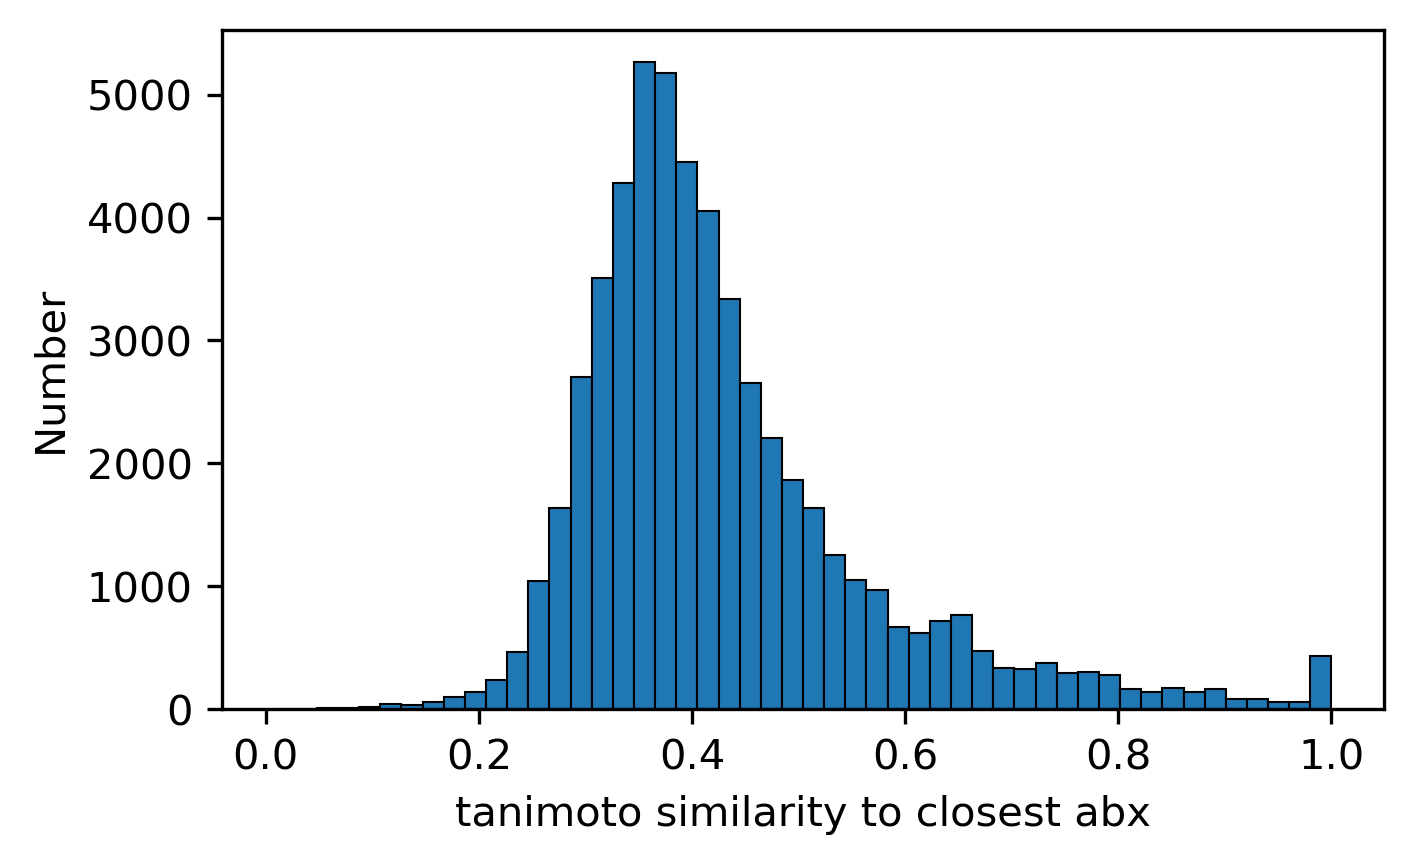

Computing tanimoto scores against training set...


RDKit WARNING: [13:03:19] WARNING: not removing hydrogen atom without neighbors
[13:03:19] WARNING: not removing hydrogen atom without neighbors


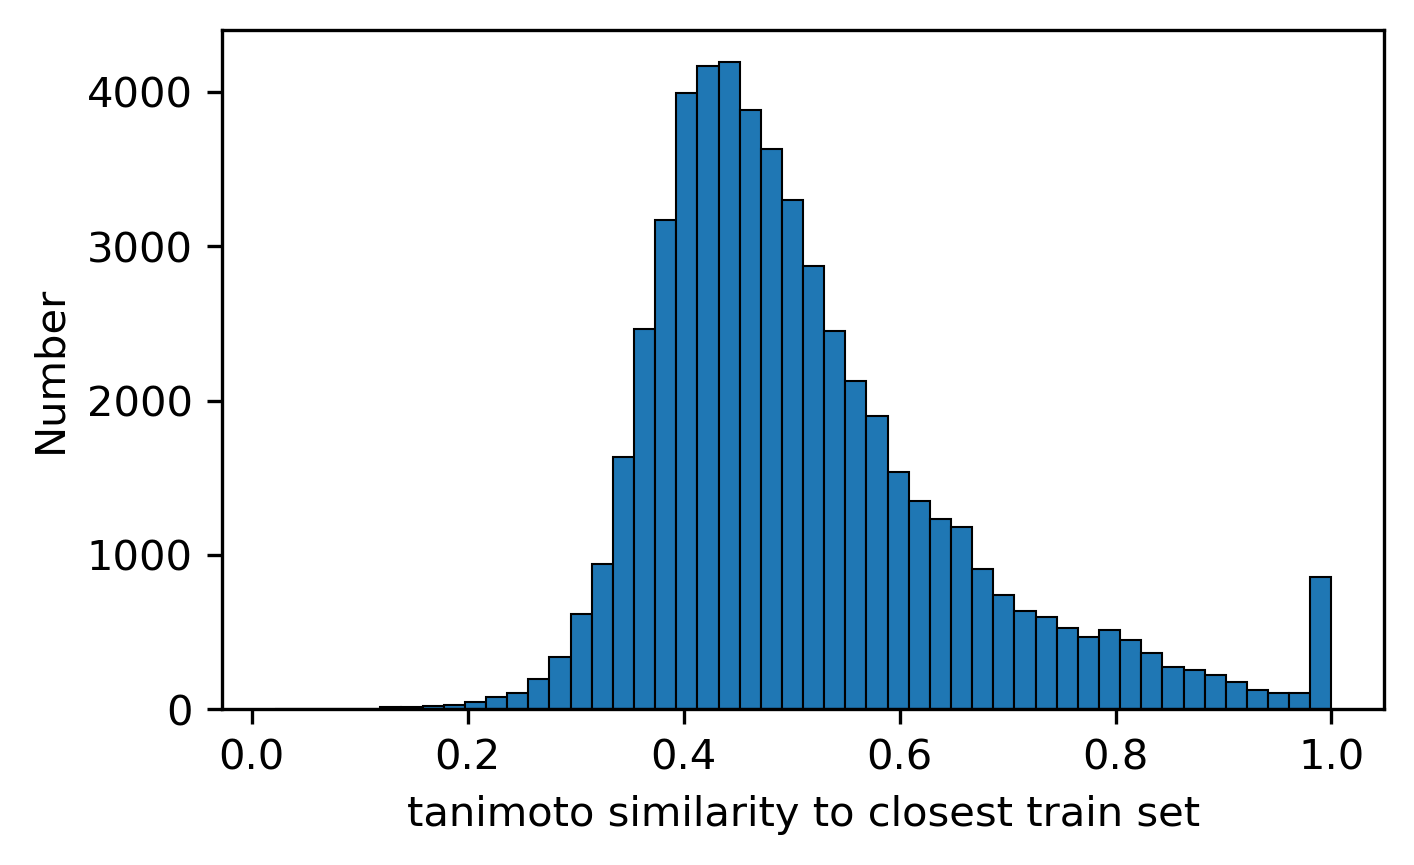

In [2]:
# read in data
data_dir = '../out/predictions_from_models/pk_37k_1round_model/5M/'
df = pd.read_csv(data_dir + 'extended_screen_set_with_FINALbayHO11152022_melis_predictions_11_22_2022.csv')
print(len(df))
meta = pd.read_csv('../data/library_info/PublicStructures.txt', sep = '\t')
df = df.merge(meta, left_on = 'SMILES', right_on = 'SMILES', how = 'left')
df = df.drop_duplicates()
df = df.reset_index(drop=True)
df.to_csv(data_dir + 'clean_preds_11_22_2022.csv', index = False)

df = evaluate_scores(df, hit_col = 'hit')
df = df[df['hit'] > 0.5] # looks like a good score cut-off to start with
df = evaluate_similarities(df, smiles_col = 'SMILES', path = data_dir, train_set_path = '../data/data_prep_for_ml/data_prep_for_ml_pk_37k_first_round_val_screen/FULL_10_26_2022.csv', thresh_name = '05', hit_col = 'hit', just_hits = True)
df.to_csv(data_dir + 'inh05_preds_with_tanimoto_analysis.csv', index = False)

In [2]:
# read in data
data_dir = '../out/predictions_from_models/pk_37k_1round_model/5M/'
df = pd.read_csv(data_dir + 'inh05_preds_with_tanimoto_analysis.csv')
df = df[df['tanimoto similarity to closest abx'] < 0.5]
df = df[df['tanimoto similarity to closest train set'] < 0.5]
df = df.sort_values('hit', ascending = False)

print('length of all preds: ', len(df))

# keep only valid frags
df, mols = keep_valid_molecules(df, 'SMILES')

# keep only frags without pains or brenk
df, mols = check_pains_brenk(df, mols, method = 'pains', thresh=0)
df, mols = check_pains_brenk(df, mols, method = 'brenk', thresh=1)

# filter for nitrofurans
df, mols = filter_for_nitrofuran(df, mols)

# filter for sulfonamides 
df, mols = filter_for_sulfonamide(df, mols)

# filter for logP
df, mols = filter_for_logp_less_than(df, mols, 5)
df, mols = filter_for_mw_bounds(df, mols, lower_bound = 200, upper_bound = 100000000)

# deduplicate based on tanimoto similarity
df = deduplicate_on_tan_sim(df, mols)
df.to_csv(data_dir + 'mols_filtered_aggressively_12092022.csv', index = False)

length of all preds:  30846


RDKit WARNING: [08:07:50] WARNING: not removing hydrogen atom without neighbors
[08:07:50] WARNING: not removing hydrogen atom without neighbors


length of df with valid mols:  30846
length of all preds with clean (no PAINS or Brenk) mols:  23848
length of all preds with clean (no PAINS or Brenk) mols:  8942


/Users/jackie16201/Desktop/Spring_2023/ngonorrhoeae_abx_ml_discovery/src/utils.py:56: DeprecationWarning: The rdkit.Chem.MCS module is deprecated; please use rdkit.Chem.rdFMCS instead.
  mcs = MCS.FindMCS([mol, pattern_mol], atomCompare='elements',completeRingsOnly = True)


length of df with no nitrofurans:  8942
length of df with no sulfonamides:  7273
length of df with logP < 5:  3442
length of df with 200 < MW < 100000000:  3418
length of all preds deduplicated:  2630


RDKit WARNING: [08:16:29] WARNING: not removing hydrogen atom without neighbors
[08:16:29] WARNING: not removing hydrogen atom without neighbors


2630


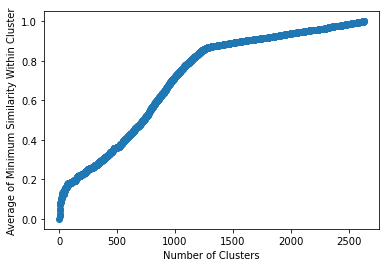

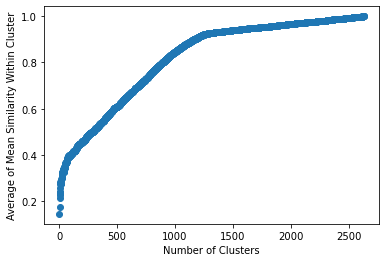

,clusters,min_sim_within_cluster
243,244,0.250003
244,245,0.250390
248,249,0.250515
249,250,0.251696
250,251,0.251502
...,...,...
2624,2625,0.999171
2625,2626,0.999418
2626,2627,0.999537
2627,2628,0.999632


In [3]:
# determine appropriate number of clusters
df, min_sims = determine_optimal_clustering_number(df, max_num_clusters = len(df), smiles_col = 'SMILES')
min_sim_df = pd.DataFrame()
min_sim_df['clusters'] = list(range(1, len(df)))
min_sim_df['min_sim_within_cluster'] = min_sims
min_sim_df = min_sim_df[min_sim_df['min_sim_within_cluster'] > 0.25]
min_sim_df

In [5]:
# plot final number of clusters
folder = data_dir + 'newfilters12092022/'
os.mkdir(folder)
df, mols = extract_legends_and_plot(df, 'grp.png', folder, num_clusters = 244, smiles_col = 'SMILES', name_col = 'Database')
df.to_csv(folder + 'finalmols.csv', index = False)

# pick highest scoring mols from each cluster
finaldf = pd.DataFrame()
for clust, smalldf in df.groupby('cluster'):
    smalldf = smalldf.sort_values('hit', ascending = False)
    smalldf = pd.DataFrame(smalldf.iloc[0,:]).T
    finaldf = pd.concat([finaldf, smalldf])
finaldf.to_csv(folder + 'finalmols_best_from_each_cluster.csv', index = False)
finaldf

RDKit WARNING: [08:07:37] WARNING: not removing hydrogen atom without neighbors
[08:07:37] WARNING: not removing hydrogen atom without neighbors


,SMILES,tanimoto similarity to closest train set,closest train set smiles,closest train set name,tanimoto similarity to closest abx,closest abx smiles,closest abx name,Database,hit,hit_epi_unc,Name,PROJECT_CODE,PROJECT_NAME,CXSMILES,STEREO_COMMENTS,row_num,cluster
37534,ClC1=C(Cl)C=C(C=C1)N1C2CS(=O)(=O)CC2NC1=S,0.439582,C=C(NC(=O)C(=C)NC(=O)c1csc(C2=NC3c4csc(n4)C4NC...,THIOSTREPTON,0.436705,NC1Cc2ccc(c(Cl)c2)Oc2cc3cc(c2O)Oc2ccc(cc2Cl)C(...,NaN,MolPort,0.652121,0.020791,NaN,NaN,NaN,NaN,NaN,332,0
35577,[Cl-].[Cl-].BrC1=CC(Br)=C2OCC(C[NH+]3CCCCC3)(C...,0.452323,CC(=CCC[C@@]1(C)Oc2c(c3c(c(c2C=C1)O)C(=O)[C@H]...,BRD-K01825016,0.43631,CCN(CC)C(=O)COc1cc2c(O)c3c(O)c(C)c4c(c13)C(=O)...,RIFAMIDE,MolPort,0.75137,0.032793,NaN,NaN,NaN,NaN,NaN,48,1
21846,ClC1=CC=CC(=C1)N1CCN(CC1)C1=C(N2CCOCC2)C(=O)C1=O,0.321083,CC(=O)NC[C@H]1CN(C(=O)O1)c1ccc(c(c1)F)N1CCN(CC...,BRD-K47554101,0.321083,CC(=O)NC[C@H]1CN(C(=O)O1)C2=CC(=C(C=C2)N3CCN(C...,EPEREZOLID,MolPort,0.665251,0.06501,NaN,NaN,NaN,NaN,NaN,266,10
43926,CC1=C(C)C(N2C(=O)C=CC2=O)=C(N2C(=O)C=CC2=O)C(C...,0.422222,Oc1ccc(cc1)N1C(=O)C=CC1=O,BRD-K70834168,0.366464,CC(C)=CCC/C(C)=C/CC/C(C)=C/CN1C(=O)c2cccc(O)c2...,DIAZEPINOMICIN,MolPort,0.795317,0.036717,NaN,NaN,NaN,NaN,NaN,15,100
32615,O=C1C(=CSC2=CC=CC=C12)N1CCC(CC2=CC=CC=C2)CC1,0.371638,O=C1C(CCC(O)c2ccc(F)cc2)C(c2ccc(O)cc2)N1c1ccc(...,EZETIMIBE,0.355716,CCN(CC)c1nc2c(s1)c1c(O)c3c(O)c(C)c4c(c32)C(=O)...,RIFAMEXIL,MolPort,0.57332,0.045455,NaN,NaN,NaN,NaN,NaN,1041,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7973,O=C(Nc1nnc(-c2cccnc2)s1)c1ccc(Cl)c(Cl)c1,0.402768,CCCCCCO[C@@H](C)c1cccc(c1OC)-c1csc(n1)NC(=O)c1...,BRD-K93228461,0.379512,CO[C@H]1/C=C/O[C@@]2(C)Oc3c(C)c(O)c4c(c3C2=O)C...,RIFABUTIN,ChemBridge Core,0.616137,0.025216,NaN,NaN,NaN,NaN,NaN,583,95
28433,ClC1=CC=C(CNCCC2=CNC3=CC=CC=C23)C=C1Cl,0.455971,FC(F)(F)c1ccc(cc1)/C=C(\C#N)c1c[nH]c2ccccc12,BRD-K82260871,0.451168,C[C@@H](C(=O)N[C@H](CC(C)C)C(=O)N[C@@H](C)C(=O...,GRAMICIDIN,MolPort,0.686486,0.019694,NaN,NaN,NaN,NaN,NaN,174,96
31537,CC(OC1=C(Cl)C=CC=C1)C(=O)NCC1=CC=C(Cl)C(Cl)=C1,0.415598,Clc1ccc(cc1)[C@@H](NC(=O)C1CCN(CCOc2ccc(cc2Cl)...,BRD-A13937616,0.320169,CC(C)(C)CC(C)(C)c1ccc(OCCOCC[N+](C)(C)Cc2ccccc...,BENZETHONIUM,MolPort,0.619376,0.009165,NaN,NaN,NaN,NaN,NaN,547,97
40396,ClC1=CC=C(NC2=CC(=O)OC3=CC=CC=C23)C=C1Cl,0.306649,COC1C(OC(N)=O)C(O)C(Oc2ccc3c([O-])c(NC(=O)c4cc...,NOVOBIOCIN SODIUM,0.291005,CO[C@@H]1[C@@H](OC(=O)c2ccc(C)[nH]2)[C@@H](O)[...,COUMERMYCIN SODIUM,MolPort,0.6432,0.019245,NaN,NaN,NaN,NaN,NaN,385,98
